In [2]:
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# Imports Scikit-Learn (Vus au TD Classification)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Ajout du chemin vers tes scripts personnels et ceux du prof
# Assure-toi que le dossier contenant libsigma est bien ici
sys.path.append('/home/onyxia/work/') 

from libsigma import read_and_write as rw
from libsigma import classification as cla
# Tu devras créer ce fichier pour tes fonctions perso comme demandé dans le projet
#import my_function as mf 

# Configuration des dossiers
data_dir = "data/"
results_dir = "results/"
fig_dir = os.path.join(results_dir, "figure/")

# Création des dossiers de sortie si inexistants (Bonne pratique TD)
os.makedirs(fig_dir, exist_ok=True)

print("Environnement chargé.")

Environnement chargé.


In [5]:
import numpy as np
from osgeo import gdal, ogr

# 1. On définit les chemins
image_ref_path = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif'
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
output_raster = '/home/onyxia/work/data/projet_eval/sample_strata.tif'

# 2. On ouvre l'image de référence pour copier ses dimensions et sa projection
raster_ds = gdal.Open(image_ref_path)
geotransform = raster_ds.GetGeoTransform()
projection = raster_ds.GetProjection()
x_size = raster_ds.RasterXSize
y_size = raster_ds.RasterYSize

# 3. On crée le nouveau fichier Raster (vide pour l'instant)
driver = gdal.GetDriverByName('GTiff')
target_ds = driver.Create(output_raster, x_size, y_size, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform(geotransform)
target_ds.SetProjection(projection)

# 4. On ouvre le Shapefile
shp_ds = ogr.Open(shp_path)
layer = shp_ds.GetLayer()

# 5. On "brûle" (rasterize) les polygones dans le raster
# On utilise la colonne 'strate' pour donner la valeur aux pixels
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=strate"])

# 6. On ferme proprement les fichiers pour sauvegarder sur le disque
target_ds.FlushCache()
target_ds = None
raster_ds = None
print(f"✅ Succès ! Le fichier raster est créé ici : {output_raster}")

✅ Succès ! Le fichier raster est créé ici : /home/onyxia/work/data/projet_eval/sample_strata.tif


Image référence : /home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif
Shapefile : /home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp

--- Analyse des Polygones ---


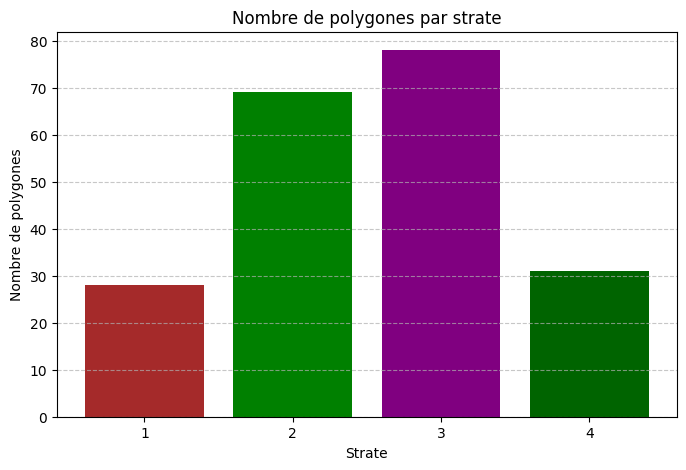


--- Rasterisation du Shapefile ---
✅ Rasterisation terminée : /home/onyxia/work/data/projet_eval/sample_strata.tif

--- Analyse des Pixels ---


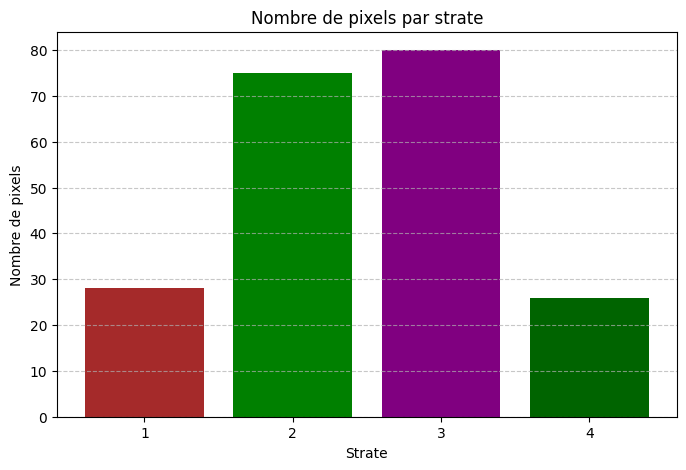

Classe 1: 28 pixels
Classe 2: 75 pixels
Classe 3: 80 pixels
Classe 4: 26 pixels


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import gdal, ogr
# On utilise tes imports libsigma
from libsigma import read_and_write as rw

# ==============================================================================
# 1. CONFIGURATION DES CHEMINS
# ==============================================================================
# Chemins basés sur ta configuration
image_ref_path = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B02.tif'
shp_path = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
output_raster = '/home/onyxia/work/data/projet_eval/sample_strata.tif'
fig_dir = 'results/figure' # Dossier pour sauver les graphiques
os.makedirs(fig_dir, exist_ok=True)

print(f"Image référence : {image_ref_path}")
print(f"Shapefile : {shp_path}")

# ==============================================================================
# 2. ANALYSE DES POLYGONES (Avec GeoPandas)
# ==============================================================================
print("\n--- Analyse des Polygones ---")
gdf = gpd.read_file(shp_path)

# On suppose la colonne 'strate' (vérifie si c'est 'classe' ou 'strate' avec gdf.head())
col_classe = 'strate' 
counts_poly = gdf[col_classe].value_counts().sort_index()

# Graphique Nombre de Polygones
plt.figure(figsize=(8, 5))
# Dictionnaire de couleurs pour harmoniser tout le projet
colors_dict = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'} 
colors_list = [colors_dict.get(i, 'gray') for i in counts_poly.index]

plt.bar(counts_poly.index.astype(str), counts_poly.values, color=colors_list)
plt.title(f"Nombre de polygones par strate")
plt.xlabel("Strate")
plt.ylabel("Nombre de polygones")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(fig_dir, "diag_baton_nb_poly_by_class.png"))
plt.show()

# ==============================================================================
# 3. RASTERISATION (Ton code GDAL)
# ==============================================================================
print("\n--- Rasterisation du Shapefile ---")

# a. Récupération infos image référence
raster_ds = gdal.Open(image_ref_path)
if raster_ds is None:
    print(f"ERREUR : Impossible d'ouvrir {image_ref_path}")
else:
    geotransform = raster_ds.GetGeoTransform()
    projection = raster_ds.GetProjection()
    x_size = raster_ds.RasterXSize
    y_size = raster_ds.RasterYSize
    raster_ds = None # Fermeture ref

    # b. Création du raster vide
    driver = gdal.GetDriverByName('GTiff')
    # On écrase si existe déjà
    if os.path.exists(output_raster):
        os.remove(output_raster)
        
    target_ds = driver.Create(output_raster, x_size, y_size, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    target_ds.SetProjection(projection)

    # c. Ouverture vecteur et Rasterisation
    shp_ds = ogr.Open(shp_path)
    layer = shp_ds.GetLayer()
    
    # "Brûlage" des polygones (ATTRIBUTE=strate)
    gdal.RasterizeLayer(target_ds, [1], layer, options=[f"ATTRIBUTE={col_classe}"])

    # d. Fermeture / Sauvegarde
    target_ds.FlushCache()
    target_ds = None
    shp_ds = None
    print(f"✅ Rasterisation terminée : {output_raster}")

# ==============================================================================
# 4. ANALYSE DES PIXELS (Avec Numpy/Matplotlib)
# ==============================================================================
print("\n--- Analyse des Pixels ---")

# Chargement du résultat
arr_samples = rw.load_img_as_array(output_raster)

# Comptage (np.unique)
classes, pixel_counts = np.unique(arr_samples, return_counts=True)

# On filtre pour ne pas compter le fond (0)
mask = classes != 0
classes_reelles = classes[mask]
counts_reels = pixel_counts[mask]

# Graphique Nombre de Pixels
plt.figure(figsize=(8, 5))
colors_list_pix = [colors_dict.get(i, 'gray') for i in classes_reelles]

plt.bar(classes_reelles.astype(str), counts_reels, color=colors_list_pix)
plt.title(f"Nombre de pixels par strate")
plt.xlabel("Strate")
plt.ylabel("Nombre de pixels")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(fig_dir, "diag_baton_nb_pix_by_class.png"))
plt.show()

# Affichage textuel pour vérification
for c, count in zip(classes_reelles, counts_reels):
    print(f"Classe {c}: {count} pixels")

Dimensions du masque d'échantillons : (1655, 2103)
Ouverture des images multibandes : 
 - data/projet_eval/pyrenees_24-25_B03.tif
 - data/projet_eval/pyrenees_24-25_B05.tif


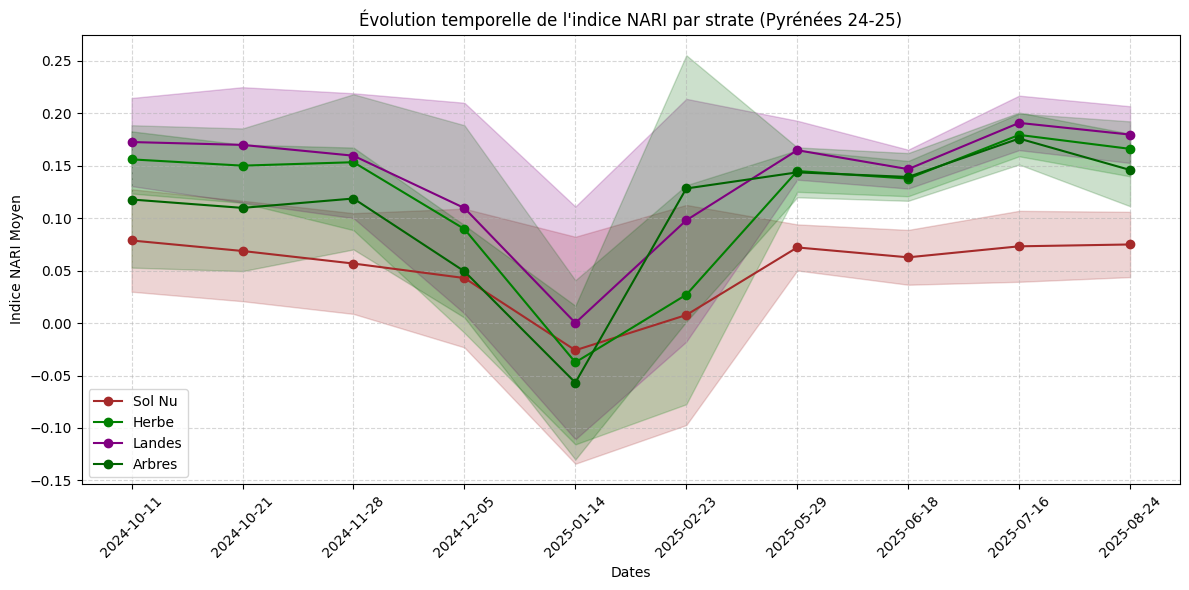

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
# On suppose que tu as importé libsigma comme 'rw' plus haut
from libsigma import read_and_write as rw

# ==============================================================================
# CONFIGURATION
# ==============================================================================

# 1. Tes dates (10 dates correspondant aux 10 bandes)
dates = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
         '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 2. Chemins exacts des fichiers multibandes
path_b03 = "data/projet_eval/pyrenees_24-25_B03.tif"
path_b05 = "data/projet_eval/pyrenees_24-25_B05.tif"

# Dictionnaires pour stocker les résultats
nari_means = {1: [], 2: [], 3: [], 4: []}
nari_stds = {1: [], 2: [], 3: [], 4: []}

# ==============================================================================
# PRÉPARATION DU MASQUE (Correction Dimension)
# ==============================================================================

# Si arr_samples n'existe pas, on le recharge
if 'arr_samples' not in locals():
    # output_raster doit être défini à l'étape 1
    output_raster = '/home/onyxia/work/data/projet_eval/sample_strata.tif'
    arr_samples = rw.load_img_as_array(output_raster)

# CORRECTION IMPORTANTE : Passage de 3D (H, W, 1) à 2D (H, W)
if arr_samples.ndim == 3:
    arr_samples_2d = arr_samples[:, :, 0]
else:
    arr_samples_2d = arr_samples

print(f"Dimensions du masque d'échantillons : {arr_samples_2d.shape}")

# ==============================================================================
# CHARGEMENT ET CALCUL
# ==============================================================================

print(f"Ouverture des images multibandes : \n - {path_b03}\n - {path_b05}")

ds_b03 = rw.open_image(path_b03)
ds_b05 = rw.open_image(path_b05)

if ds_b03 is None or ds_b05 is None:
    print("ERREUR CRITIQUE : Impossible d'ouvrir les fichiers.")
else:
    nb_bandes = ds_b03.RasterCount
    
    # Boucle sur les bandes (1 bande = 1 date)
    for i in range(min(len(dates), nb_bandes)):
        date = dates[i]
        idx_gdal = i + 1
        
        try:
            b03 = ds_b03.GetRasterBand(idx_gdal).ReadAsArray().astype(np.float32)
            b05 = ds_b05.GetRasterBand(idx_gdal).ReadAsArray().astype(np.float32)
        except Exception as e:
            print(f"❌ Erreur lecture bande {idx_gdal} : {e}")
            continue

        # Calcul NARI
        with np.errstate(divide='ignore', invalid='ignore'):
            inv_b3 = 1 / b03
            inv_b5 = 1 / b05
            nari = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)
        
        # Extraction des stats par classe
        for c in [1, 2, 3, 4]:
            # On utilise arr_samples_2d qui a les bonnes dimensions
            mask_class = (arr_samples_2d == c)
            
            # Gestion des dimensions (rognage si différence de taille)
            if nari.shape != mask_class.shape:
                 min_r = min(nari.shape[0], mask_class.shape[0])
                 min_c = min(nari.shape[1], mask_class.shape[1])
                 # On découpe les deux tableaux à la taille minimale commune
                 vals = nari[:min_r, :min_c][mask_class[:min_r, :min_c]]
            else:
                 vals = nari[mask_class]
                 
            vals = vals[~np.isnan(vals)]
            
            if len(vals) > 0:
                nari_means[c].append(np.mean(vals))
                nari_stds[c].append(np.std(vals))
            else:
                nari_means[c].append(np.nan)
                nari_stds[c].append(np.nan)

    ds_b03 = None
    ds_b05 = None

    # ==============================================================================
    # AFFICHAGE GRAPHIQUE
    # ==============================================================================

    plt.figure(figsize=(12, 6))
    colors = {1: 'brown', 2: 'green', 3: 'purple', 4: 'darkgreen'}
    labels = {1: 'Sol Nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbres'}
    
    x_axis = range(len(dates))

    for c in [1, 2, 3, 4]:
        mu = np.array(nari_means[c])
        sigma = np.array(nari_stds[c])
        
        if len(mu) == len(x_axis) and not np.all(np.isnan(mu)):
            plt.plot(x_axis, mu, label=labels[c], color=colors[c], marker='o')
            plt.fill_between(x_axis, mu - sigma, mu + sigma, color=colors[c], alpha=0.2)

    plt.xticks(x_axis, dates, rotation=45)
    plt.title("Évolution temporelle de l'indice NARI par strate (Pyrénées 24-25)")
    plt.xlabel("Dates")
    plt.ylabel("Indice NARI Moyen")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, "ARI_series.png"))
    plt.show()

In [ ]:
# 1. Rasteriser les IDs des polygones (si pas déjà fait)
# Supposons que ton SHP a une colonne 'id' unique pour chaque polygone
out_raster_ids = os.path.join(results_dir, "PI_ids_rasterized.tif")
cmd_id = f"gdal_rasterize -a id -te {minx} {ymin} {xmax} {maxy} -tr {px} {abs(py)} -ot UInt16 -of GTiff {shp_path} {out_raster_ids}"
os.system(cmd_id)

# 2. Construction de la stack d'images (X)
# Liste toutes tes bandes pour la classif
images_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.tif') and "SENTINEL" in f]
# (Tu devras peut-être faire une fonction pour empiler proprement tout ça ou utiliser un VRT gdal)

# Pour l'exemple, supposons que tu as créé un gros fichier 'stack.tif' ou que tu boucle pour extraire
# Utilisons la fonction du cours : get_samples_from_roi
# Attention : il faut adapter pour charger plusieurs bandes. 
# Ici, je simplifie : supposons que tu as une image multibande 'image_complete.tif'
image_complete = os.path.join(data_dir, "stack_toutes_dates.tif") 

# Extraction X (Features) et Y (Labels)
X, Y, t = cla.get_samples_from_roi(image_complete, out_raster_samples)

# Extraction des Groupes (IDs polygones) au MÊME endroits que les pixels X
# On utilise la même fonction mais avec l'image des IDs
_, groups, _ = cla.get_samples_from_roi(out_raster_ids, out_raster_samples)
groups = groups.ravel() # Aplatir pour Scikit-Learn
Y = Y.ravel()

print(f"Dimensions X: {X.shape}, Y: {Y.shape}, Groups: {groups.shape}")

In [ ]:
# Configuration du modèle
rf = RandomForestClassifier(random_state=42)

# Grille d'hyperparamètres (Tableau 4 du sujet)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 5]
}

# Stratégie de validation (TD Classif Partie 2)
# On utilise les groupes pour que les pixels d'un même polygone ne soient pas séparés
cv = StratifiedGroupKFold(n_splits=5)

# Recherche sur grille
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted', # Métrique demandée
    n_jobs=-1, # Parallélisation (vu dans "Pistes Techniques")
    verbose=2
)

# Entraînement (ATTENTION : passer 'groups' ici est crucial)
print("Début de l'optimisation...")
grid_search.fit(X, Y, groups=groups)

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score F1 : {grid_search.best_score_:.4f}")

# Modèle final
best_clf = grid_search.best_estimator_

In [ ]:
# Prédiction (Idéalement sur un jeu de test séparé au début, mais ici on regarde la perf globale ou via CV)
# Pour faire propre selon le cours : utiliser cross_val_predict ou garder un set de test.
# Ici, regardons la performance sur le jeu complet (à nuancer dans le rapport) ou issue de la CV.

Y_pred = best_clf.predict(X)

# Rapport
print(classification_report(Y, Y_pred))

# Matrice de confusion (Matplotlib pur)
cm = confusion_matrix(Y, Y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels.values(), rotation=45)
plt.yticks(tick_marks, labels.values())

# Ajout des textes dans les cases
import itertools
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Importance des variables (Matplotlib)
importances = best_clf.feature_importances_
# Créer des noms de variables (ex: B2_date1, B3_date1...)
feature_names = [f"Band_{i}" for i in range(X.shape[1])] 
indices = np.argsort(importances)[::-1][:15] # Top 15

plt.figure(figsize=(10, 6))
plt.title("Importance des variables (Top 15)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis() # Plus important en haut
plt.show()

In [ ]:
# 1. Chargement de l'image complète pour inférence
# (Utilise ton image stackée ou boucle par blocs si l'image est trop grosse - ici version simple RAM)
ds_full = rw.open_image(image_complete)
full_img_arr = rw.load_img_as_array(image_complete)

# 2. Reshape pour scikit-learn (lignes*cols, bandes)
n_rows, n_cols, n_bands = full_img_arr.shape
X_full = full_img_arr.reshape(-1, n_bands)

# Gestion des NaNs ou NoData éventuels (remplacer par 0 ou gérer via masque)
X_full = np.nan_to_num(X_full)

# 3. Prédiction
print("Prédiction en cours sur l'image entière...")
Y_full_pred = best_clf.predict(X_full)

# 4. Reshape inverse vers image (lignes, cols)
map_pred = Y_full_pred.reshape(n_rows, n_cols)

# 5. Écriture du résultat (Fonction write_image du TD Raster/libsigma)
out_map_path = os.path.join(results_dir, "carte_strates.tif")

# On utilise le dataset d'origine pour copier la projection/geotransform
rw.write_image(out_map_path, map_pred, data_set=ds_full, gdal_dtype=gdal.GDT_Byte)

print(f"Carte sauvegardée sous : {out_map_path}")